#### In this project, I constructed a five-factor model (consisting of reversal, liquidity, scale, value, and growth) and utilized a long/short equity strategy to hedge against market exposures. Backtesting of the strategy in the Chinese stock market between 2010 and 2022 achieves an alpha (annualized risk-free excess return) of 22.5% and a Sharpe ratio of 1.48.

#### Low-attention stocks are identified across the entire market every six months , which may have relatively poor fundamental conditions but still contain individual stocks with very high growth potential. The long and short positions of the portfolio are rebalanced monthly and only low-attention stocks are selected for the portfolio.


### 1. The reversal factor (consisting of monthly reversal and price-volume correlation)

(1) Monthly reversal: The difference in mean returns between days with the top 20% and bottom 20% stock price volatility over the past 20 trading days. Stock price volatility=[(daily high-daily low)/previous close]

(2) Price-volume correlation:
The Pearson correlation coefficient between stock turnover rate on day T and stock price on day T+1 over the past 20 trading days.
 
The reversal factor helps to pick out stocks which have relatively low returns over the past month but are expected to perform well in the following month due to the short-term reversal anomaly. The time series data for both monthly reversal and price-volume correlation are standardized cross-sectionally and then added together to give the reversal factor. Both are negatively correlated with stock returns, hence the minus sign.<br>

__The reversal factor = - (monthly reversal) - (price-volume correlation)__<br>
__Information Coefficient: 9%__

### 2. The liquidity factor (consisting of volatility, turnover rate, and price elasticity)

(1) Volatility: The standard deviation of (daily high/daily low) over the past 20 trading days

(2) Turnover rate: The standard deviation of stock turnover rate over the past 20 trading days

(3) Price elasticity (the Amihud illiquidity measure): The mean value of (daily return/daily trading volume) over the past 20 trading days.

Stocks with relatively low liquidity often tend to outperform more liquid ones due to a higher expected return as compensation for higher trading cost and risk. All three factors are standardized and then combined together to give the liquidity factor. Volatility and turnover rate are negatively correlated with stock returns, hence the minus sign.<br>

__The liquidity factor = price elasticity - volatility - turnover rate__<br>
__Information Coefficient: 12%__

### 3. The size factor

It is taken as the logarithm of the market capitalization. Small-cap stocks tend to outperform large-cap stocks.<br>

__The size factor = - ln (market cap)__<br>
__Information Coefficient: 5.7%__

### 4. The value factor

It is taken as the book-to-market ratio and is used to pick out undervalued stocks which are expected to increase in price.<br>

__The value factor = book-to-market ratio__<br>
__Information Coefficient: 7.5%__

### 5. The growth factor

All stocks are first assigned values of 1, 2 and 3 based on their revenue growth in the cross-section. The same procedure is then repeated based on the acceleration of revenue growth (taken as the difference in revenue growth). These two indices are added to give a final score ranging from 2 to 6, which reflects the growth speed of the individual company. The growth factor picks out stocks with high growth potential.

__The growth factor = Revenue growth and acceleration score__<br>
__Information Coefficient: 4.8%__

### It is worth noting that all the code written for calculating the five factors are contained in other python files in this repository. They are not displayed here due to the large amount of time it takes to load and process the historical market data, which involves thousands of stocks and spans for 12 years.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pickle
import alphalens

In [174]:
# essential functions

# standardization
def stan(x):
    mean=x.mean()
    std=x.std()
    return (x-mean)/std

# calculating maximum drawdown
def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns / peak) - 1
    return drawdown.min()

# using the median absolute deviation (MAD) to identify outliers in the cross-section, 
# and cap them at 3 MADs away from the median
from scipy.stats import median_abs_deviation as mad
def madf(df,n):
    median=np.median(df)
    sd=mad(df)
    up=median+n*sd
    down=median-n*sd
    return df.clip(down,up)

# This function divides the stocks into quantiles based on the size of a certain factor, 
# it also organizes the data into a certain format for analysis by Alphalens
# Inputs: factor value, price info, lists of low-attention stocks, number of quantiles (set to 40)

def quantile(factor,openp, stock,num_of_quant):
    resultlist=[]
    months=date[:-1]
    for idx, month in enumerate(months):
        if idx % 6 ==0:
            stocknum=int(idx/6)
            newss=factor.loc[:,stock[stocknum]]
            newss2=newss.iloc[idx:idx+6]
            ss1=pd.DataFrame(newss2.stack())
            ss1.index.set_names(['date','asset'],inplace=True)
            ss1.columns=['factor']
        
            newclose=openp.loc[:,stock[stocknum]]
            newclose=newclose.iloc[idx:idx+7]
        
            result=alphalens.utils.get_clean_factor_and_forward_returns(\
                ss1,newclose,quantiles=num_of_quant,periods=[1],max_loss=1)
            resultlist.append(result)
            
    output=pd.concat(resultlist)
    return output

# This function extracts the lists of stocks in the top and bottom quantiles. These would be respectively 
# stocks in the long and short positions every month during rebalancing.

def positions(quantiles):
    data=quantiles['factor_quantile']
    top=[]
    bot=[]
    for i in range(144):
        v=data.loc[date[i]]
        d=[]
        e=[]
        for k in range(len(v)):
            if v.iloc[k]==40:
                d.append(v.index[k])
            if v.iloc[k]==1:
                e.append(v.index[k])
        top.append(d)
        bot.append(e)
    return top, bot
        
# This function calculates the total return of portfolio every month based on the price changes of stocks in
# the long and short positions. It also updates the new total value of asset every month, which can be plotted.

def net_value(top_pos, bot_pos,ratio=0.5,openp=price):
    money=1
    net=[1]
    openp.index=np.arange(145)
    shortratio=ratio
    longratio=1-shortratio
    longm=longratio
    shortm=shortratio
    long=[longm]
    short=[shortm]

    for i in range(0,144):
        longda=openp.loc[i:i+1,top_pos[i]]
        shortda=openp.loc[i:i+1,bot_pos[i]]
        longret=longda.iloc[-1,:]/longda.iloc[0,:]
        shortret=shortda.iloc[-1,:]/shortda.iloc[0,:]
        shortcap=shortratio*money*shortret/len(shortret)
        longcap=longratio*money*longret/len(longret)
        longpro=(np.sum(longcap)-money*longratio)
        shortpro=money*shortratio-np.sum(shortcap)
        profit=longpro+shortpro
        money=money+profit
        
        # calculating trading costs each month and subtracting them
        if i<143:
            equal=pd.Series([1]*len(top_pos[i+1]),index=top_pos[i+1])
            target=equal*money*longratio/len(top_pos[i+1])
            exp=abs(target.sub(longcap,fill_value=0))
            exp=np.sum(exp)*(2/1000)/2 
        if i==143:
            exp=money*2/1000
        exp2=shortratio*money*(0.1/12+0.3/100)
        
        money=money-(exp+exp2)
        longm=longm+longpro-exp
        shortm=shortm+shortpro-exp2
        long.append(longm)
        short.append(shortm)
        net.append(money)
    
    netval=pd.DataFrame(net,index=date,columns=['price'])
    longprofit=pd.DataFrame(long,index=date,columns=['price'])
    shortprofit=pd.DataFrame(short,index=date,columns=['price'])
    return netval, longprofit, shortprofit

In [175]:
# loading all the processed factors and other relevant data

# date index
start_date = '2010-07-01'
end_date = '2022-07-01'
date = pd.date_range(start=start_date, end=end_date, freq='MS')

# open price of stocks at the start of every month from 2010.07 to 2022.07
price=pd.read_excel('开盘价.xlsx',skiprows=1,index_col=0)
price.index=date

# loading the five factors
with open('反转因子.pkl', 'rb') as file:
    reversal = pickle.load(file)
reversal=reversal.iloc[0:-1,:]

with open('流动因子.pkl', 'rb') as file:
    liquidity = pickle.load(file)
liquidity=liquidity.iloc[0:-1,:]

with open('规模因子.pkl', 'rb') as file:
    size = pickle.load(file)

with open('价值因子.pkl', 'rb') as file:
    value = pickle.load(file)

with open('qpt因子.pkl', 'rb') as file:
    growth = pickle.load(file)

# Lists of selected low-attention stocks, refreshed twice a year
with open('持仓.pkl', 'rb') as file:
    low_att_stocks = pickle.load(file)

# loading the benchmark index for comparison
zhongzheng=pd.read_excel('中证.xlsx',index_col=0,names=['price'])
zhongzheng.index=date
zhongzheng=1*zhongzheng/zhongzheng.iloc[0]
marvo=zhongzheng.pct_change()
marvo.drop(['20100701'],inplace=True)

# sector and industry information of all stocks
industry=pd.read_excel('行业.xlsx')
industry=pd.DataFrame(industry.loc[1].drop(['代码'],axis=0))
industry.drop('Code',axis=0,inplace=True)

### The following steps are carried out when combining the five factors into the final factor:
1. The factors are adjusted in direction to ensure positive correlations with returns, and empty values are filled with zeros first
2. Detection and capping of outliers in cross-sections using the MAD method (capping at 3 MADs away)
3. Sector neutralization serves to reduce the impact of certain sector-specific risks on the portfolio. This is done by grouping all the stocks according to their sectors (eg. energy, real estate, technology, etc.) and then performing standardizations within all groups.
4. Removing effect of size (market capitalization) on other factors by performing a linear regression and taking the residuals. This is due to size having a strong negative correlation with returns, especially in the Chinese stock market a few years ago.
5. The last step is to standardize all factors again before adding them together to obtain the final factor

In [176]:
# Adjusting direction and filling empty values (step 1)
size=1/size
liquidity.fillna(0,inplace=True)
size.fillna(0,inplace=True)
growth.fillna(0,inplace=True)
reversal.fillna(0,inplace=True)
value.fillna(0,inplace=True)

# capping outliers using MAD (step 2)
f=3*1.4826  # The constant 1.4826 puts MAD on the same scale as standard deviation 
for i in range(144):
    liquidity.iloc[i,:]=madf(liquidity.iloc[i,:],f)
    size.iloc[i,:]=madf(size.iloc[i,:],f)
    reversal.iloc[i,:]=madf(reversal.iloc[i,:],f)
    growth.iloc[i,:]=madf(growth.iloc[i,:],f)
    value.iloc[i,:]=madf(value.iloc[i,:],f)
    
# Removing effect of sector and size on factors (steps 3 & 4)
for i in range(144):
    r=reversal.iloc[i,:]
    l=liquidity.iloc[i,:]
    g=growth.iloc[i,:]
    v=value.iloc[i,:]
    s=size.iloc[i,:]
    s.name=None
    r.name=None
    l.name=None
    g.name=None
    v.name=None
    
    e=pd.merge(industry,pd.DataFrame(s),on=industry.index)
    e.set_index('key_0',inplace=True)
    e2=e.groupby(1).transform(stan)
    size.iloc[i,:]=e2.iloc[:,0]
    s=size.iloc[i,:]
    
    a=pd.merge(industry,pd.DataFrame(r),on=industry.index)
    a.set_index('key_0',inplace=True)
    a2=a.groupby(1).transform(stan)
    r=a2.iloc[:,0]
    model1=sm.OLS(r,sm.add_constant(s)).fit()
    r=model1.resid
    reversal.iloc[i,:]=r
    
    b=pd.merge(industry,pd.DataFrame(l),on=industry.index)
    b.set_index('key_0',inplace=True)
    b2=b.groupby(1).transform(stan)
    l=b2.iloc[:,0]
    model2=sm.OLS(l,sm.add_constant(s)).fit()
    l=model2.resid
    liquidity.iloc[i,:]=l
    
    c=pd.merge(industry,pd.DataFrame(g),on=industry.index)
    c.set_index('key_0',inplace=True)
    c2=c.groupby(1).transform(stan)
    g=c2.iloc[:,0]
    model3=sm.OLS(g,sm.add_constant(s)).fit()
    g=model3.resid
    growth.iloc[i,:]=g
    
    d=pd.merge(industry,pd.DataFrame(v),on=industry.index)
    d.set_index('key_0',inplace=True)
    d2=d.groupby(1).transform(stan)
    v=d2.iloc[:,0]
    model4=sm.OLS(v,sm.add_constant(s)).fit()
    v=model4.resid
    value.iloc[i,:]=v

In [178]:
# standardization of each factor before addition (step 5)
for i in range(144):
    reversal.iloc[i,:]=stan(reversal.iloc[i,:])
    liquidity.iloc[i,:]=stan(liquidity.iloc[i,:])
    size.iloc[i,:]=stan(size.iloc[i,:])
    growth.iloc[i,:]=stan(growth.iloc[i,:])
    value.iloc[i,:]=stan(value.iloc[i,:])

factor = reversal + liquidity + size + growth + value
factor.index=date[:-1]

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.

,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-10.174367,-3.748739,-5.793375,0.942288,1224,2.626497
2,-6.471889,-3.066321,-4.530394,0.516945,1170,2.510622
3,-5.511481,-2.639575,-3.869732,0.479442,1152,2.471997
4,-4.689549,-2.257674,-3.355404,0.445645,1182,2.536372
5,-4.391859,-2.068869,-2.962607,0.416392,1158,2.484872
6,-4.123441,-1.784070,-2.640844,0.390903,1146,2.459122
7,-3.709878,-1.451806,-2.356803,0.373702,1158,2.484872
8,-3.415152,-1.077824,-2.105230,0.361877,1182,2.536372
9,-3.128159,-0.738846,-1.864770,0.349130,1140,2.446247


Returns Analysis


/opt/anaconda3/lib/python3.9/site-packages/alphalens/plotting.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns_table = returns_table.append(alpha_beta)


,1D
Ann. alpha,40.464
beta,-0.042
Mean Period Wise Return Top Quantile (bps),298.807
Mean Period Wise Return Bottom Quantile (bps),-226.389
Mean Period Wise Spread (bps),525.196


/opt/anaconda3/lib/python3.9/site-packages/alphalens/tears.py:273: UserWarning: 'freq' not set in factor_data index: assuming business day
  warnings.warn(


<Figure size 432x288 with 0 Axes>

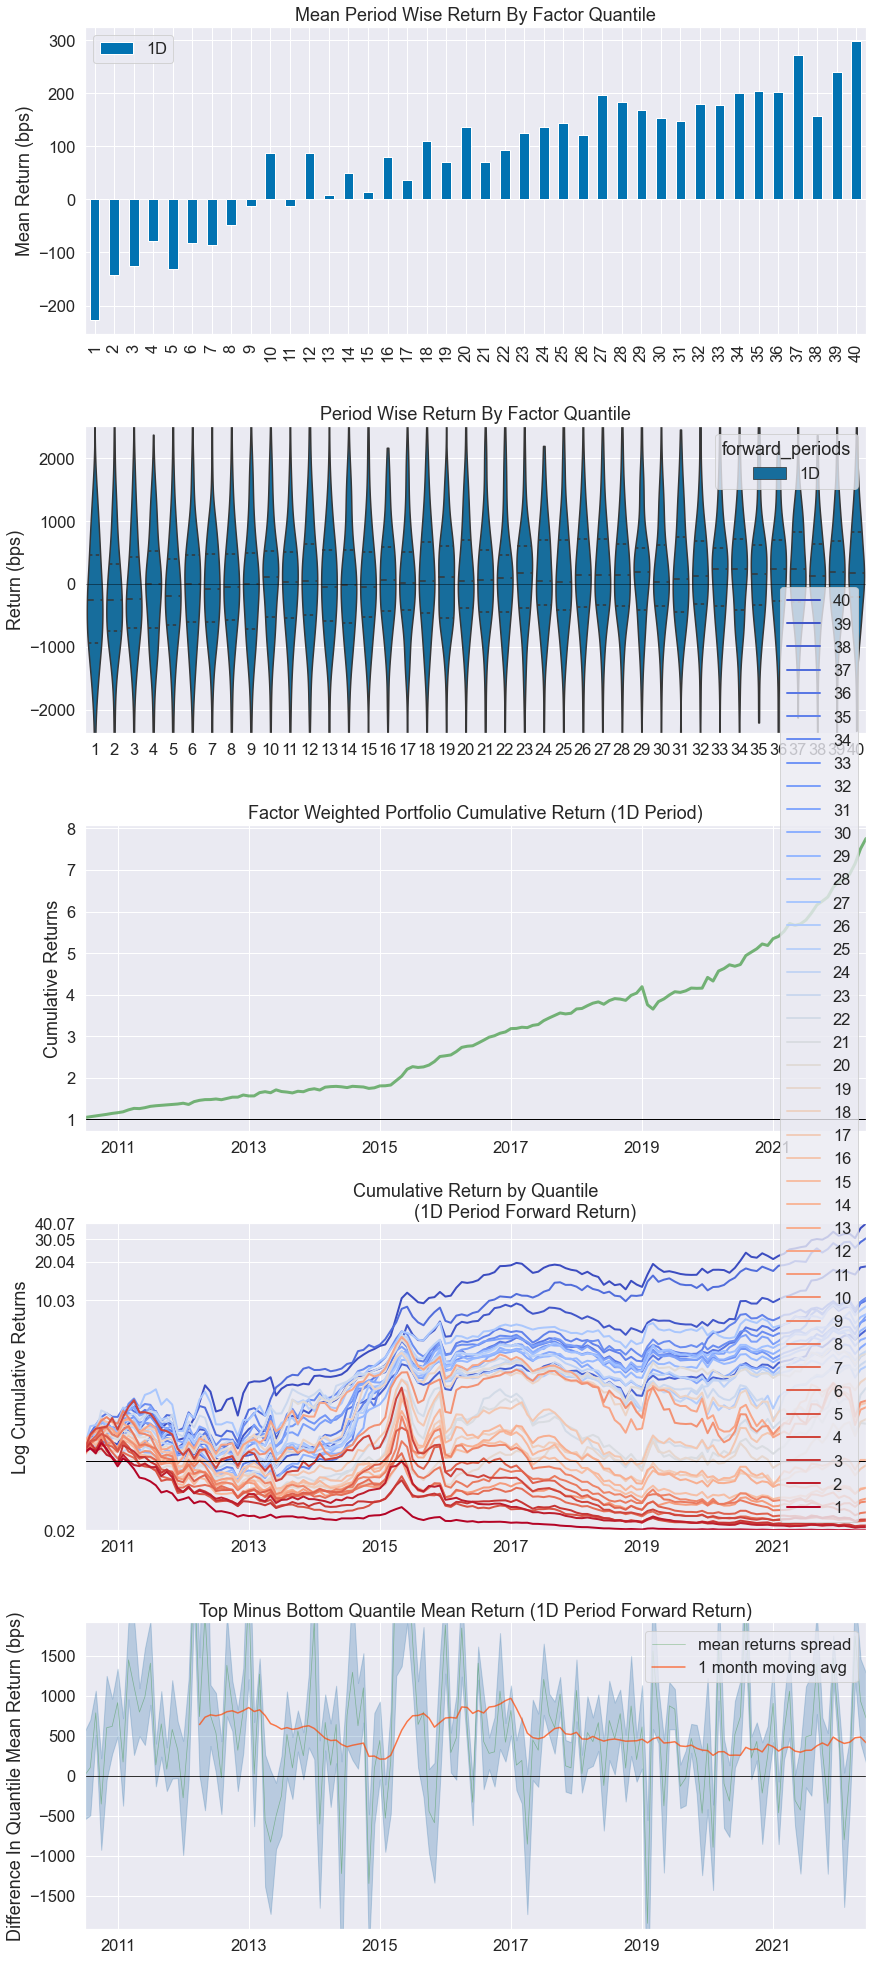

Information Analysis


,1D
IC Mean,0.151
IC Std.,0.108
Risk-Adjusted IC,1.402
t-stat(IC),16.830
p-value(IC),0.000
IC Skew,-0.141
IC Kurtosis,-0.184


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


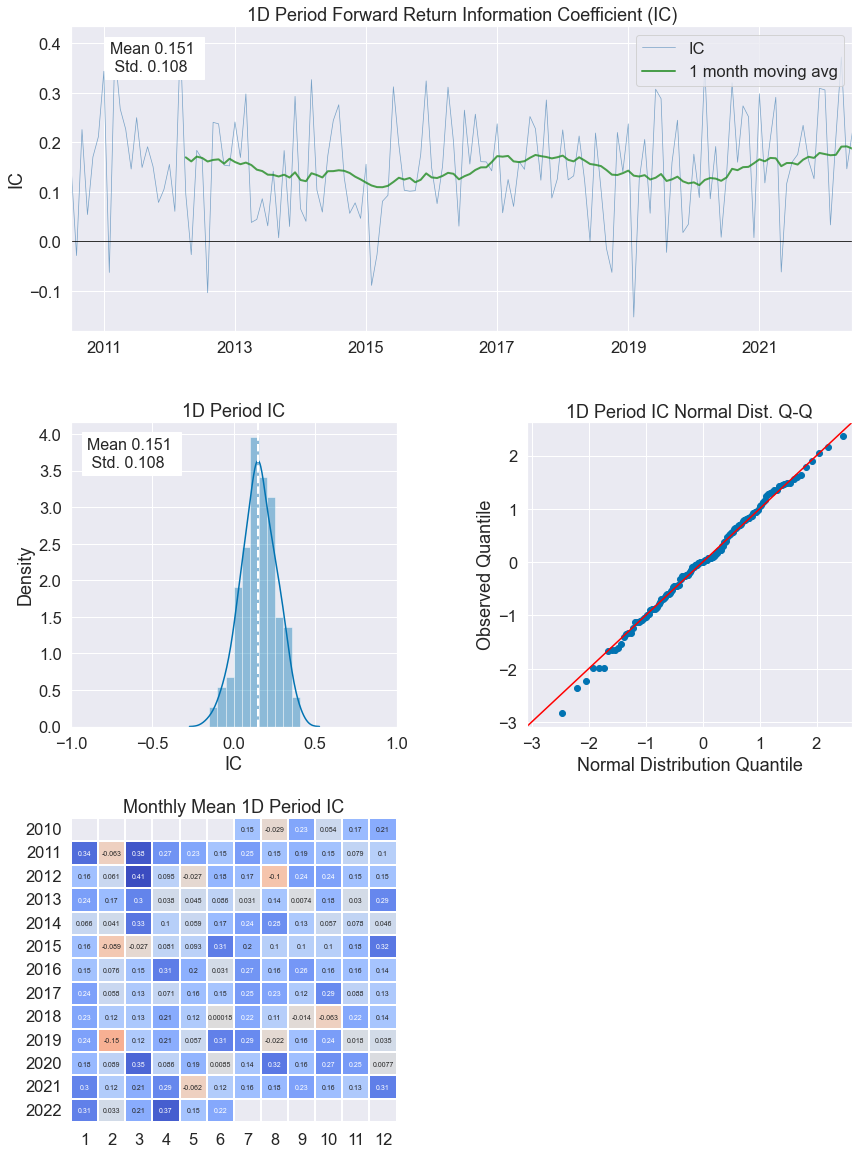

/opt/anaconda3/lib/python3.9/site-packages/alphalens/utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.792
Quantile 2 Mean Turnover,0.916
Quantile 3 Mean Turnover,0.926
Quantile 4 Mean Turnover,0.953
Quantile 5 Mean Turnover,0.956
Quantile 6 Mean Turnover,0.963
Quantile 7 Mean Turnover,0.963
Quantile 8 Mean Turnover,0.969
Quantile 9 Mean Turnover,0.956
Quantile 10 Mean Turnover,0.959


,1D
Mean Factor Rank Autocorrelation,0.559


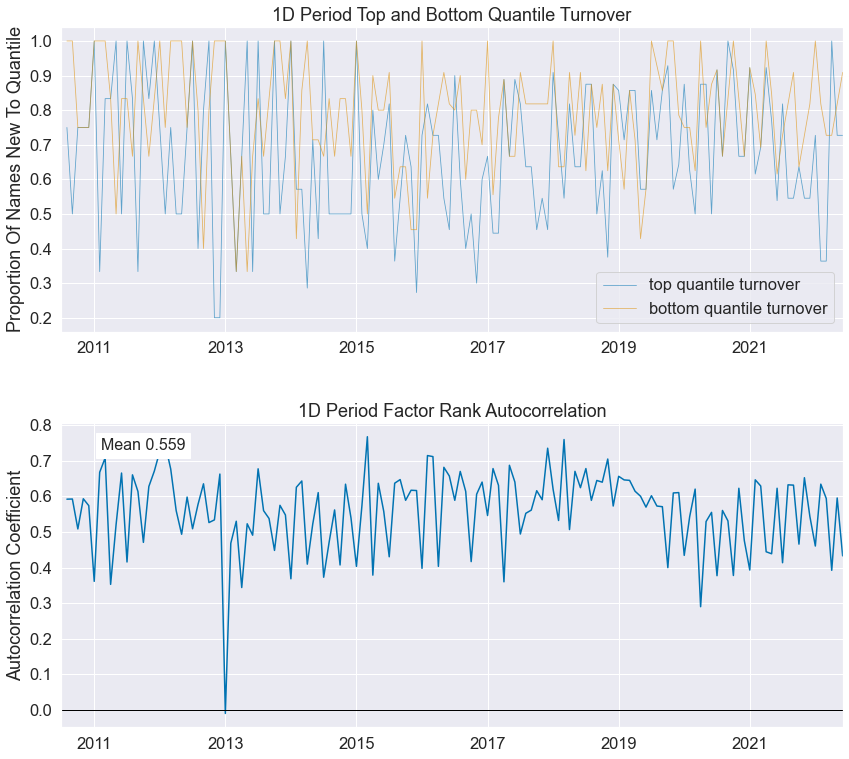

In [179]:
# Quantile information of stocks for each month
quantile_info=quantile(factor,price, low_att_stocks,num_of_quant=40)
# Detailed analysis of factor performance (generated by alphalens)
alphalens.tears.create_full_tear_sheet(quantile_info,long_short=False)

In [180]:
# Long and short positions for each month based on factor value
long, short = positions(quantile_info)

# Backtesting the strategy
# ratio = 0.5 ensures market neutrality: same amount of money assigned to long and short positions
netval, longprofit, shortprofit = net_value(top_pos=long, bot_pos=short, ratio=0.5, openp=price)

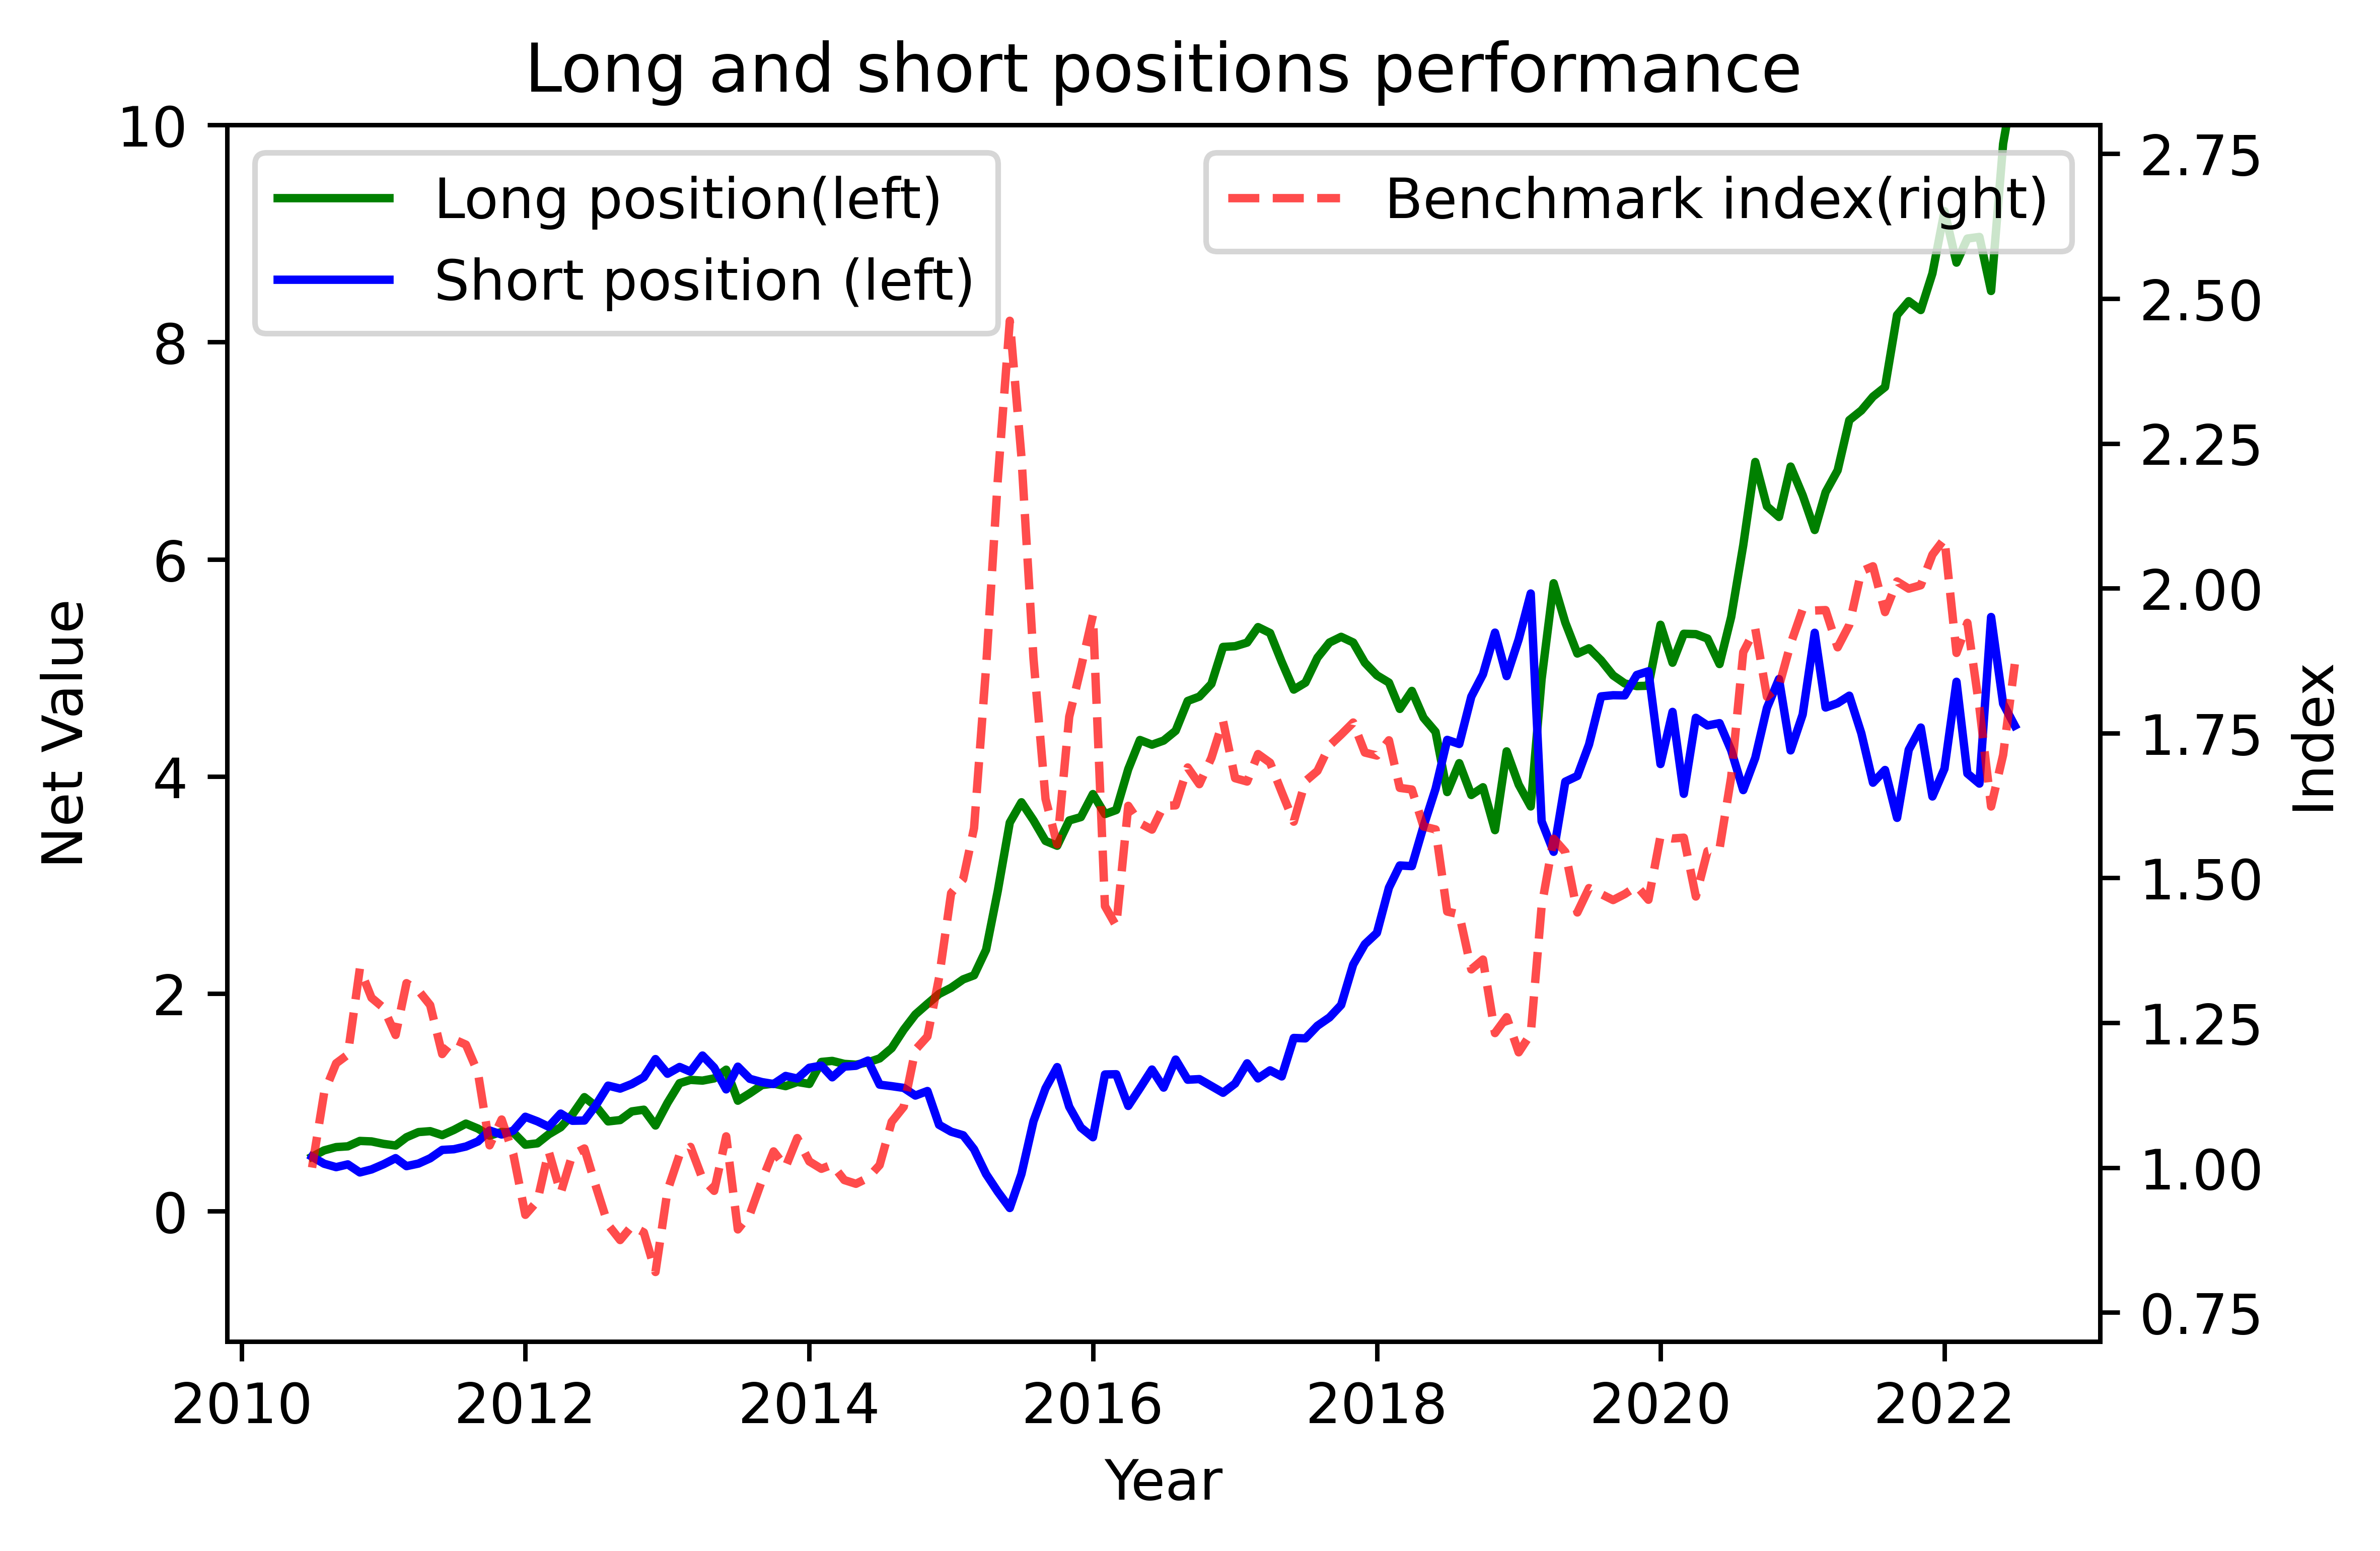

In [181]:
# Comparing performances of the long and short positions
fig, ax1 = plt.subplots(dpi=800)
ax1.plot(longprofit,label='Long position(left)',c='green')
ax1.plot(shortprofit,label='Short position (left)',c='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Net Value')
ax2 = ax1.twinx()
ax2.plot(zhongzheng,label='Benchmark index(right)',c='red',alpha=0.7,linestyle='--')
ax2.set_ylabel('Index')
ax2.set_ylim(0.7,2.8)
ax1.set_ylim(-1.2,10)
ax1.legend()
ax2.legend()
plt.title('Long and short positions performance')
plt.show()

### It can be observed that the net value of the long position moves in the same direction as the index as expected; on the other hand, the net value of the short position moves in the opposite direction. By using a 50/50 long-short strategy, I am able to hedge against market risks and maintain a steady increase in net value in all years.

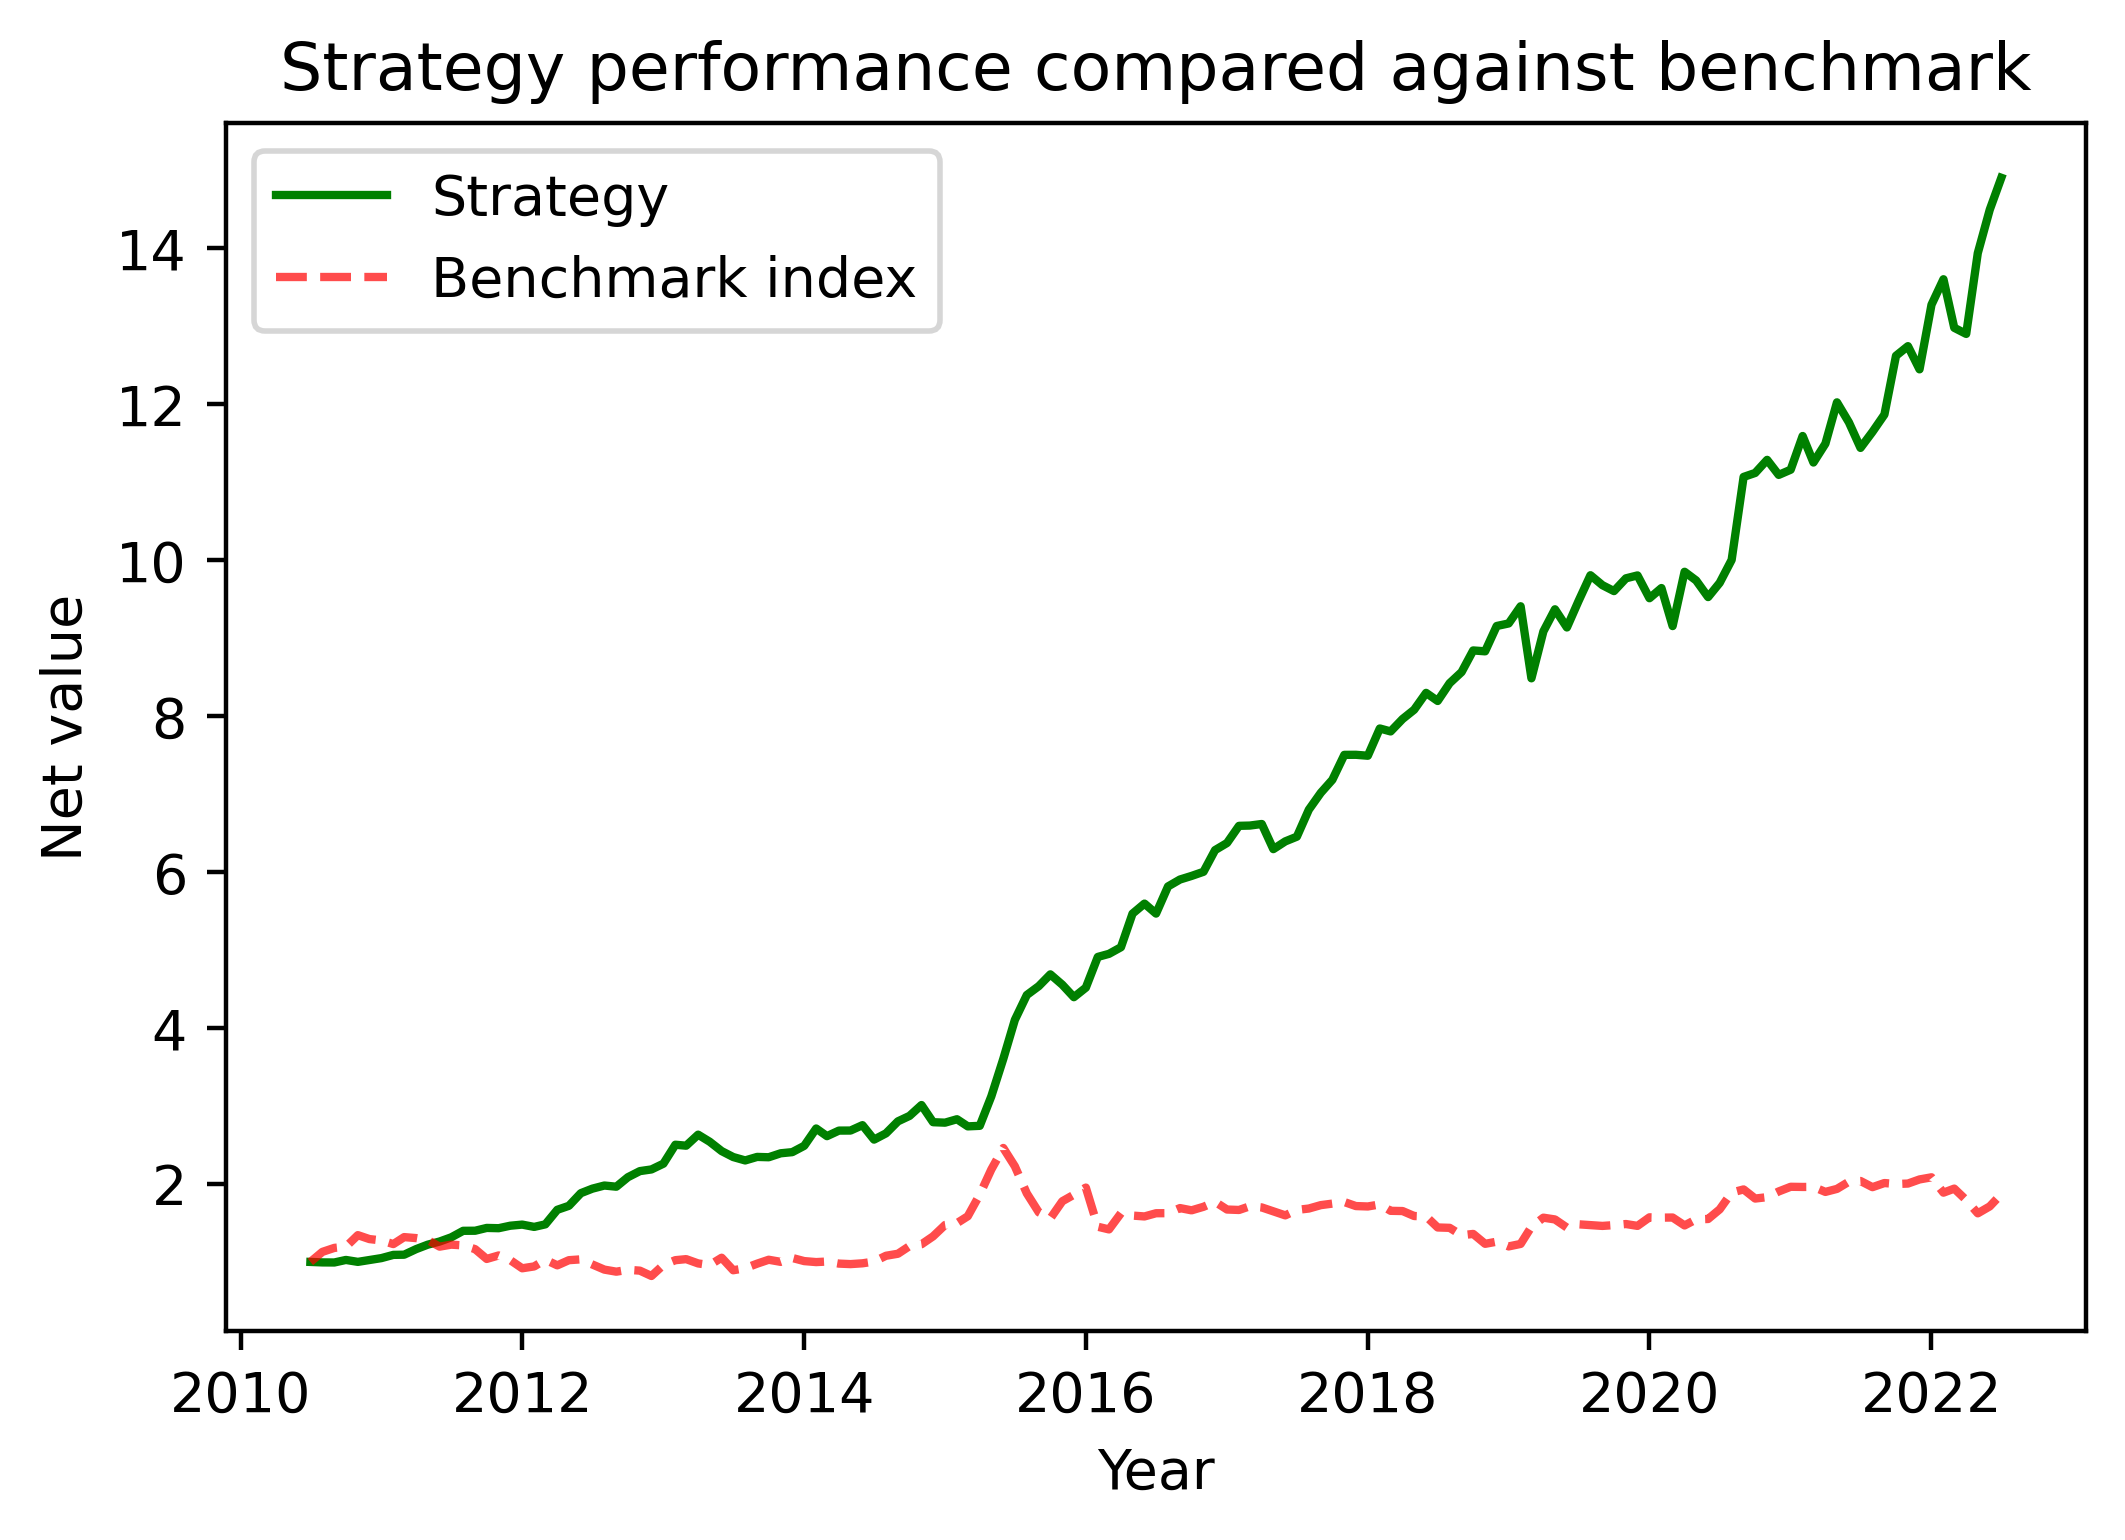

In [182]:
# plotting result of backtest
fig, ax1 = plt.subplots(dpi=400)
ax1.plot(netval,label='Strategy',c='green')
ax1.set_xlabel('Year')
ax1.set_ylabel('Net value')
ax1.plot(zhongzheng,label='Benchmark index',c='red',alpha=0.7,linestyle='--')

plt.legend()
plt.title('Strategy performance compared against benchmark')
plt.show()

In [196]:
# returns of strategy and benchmark index
returns=netval.pct_change()
basereturns=zhongzheng.pct_change()
basereturns.drop(['20100701'],inplace=True)
returns.drop(['20100701'],inplace=True)

# calculating beta using covariance matrix
cova=np.cov(returns.T,basereturns.T)
beta=cova[0,1]/cova[1,1]
print('beta:',beta)

# calculating alpha (the risk-adjusted excess return)
ann=((netval.iloc[-1][0]/1)**(1/12)-1)*100
baseann=((zhongzheng.iloc[-1][0]/1)**(1/12)-1)*100
alpha=ann-3-beta*(baseann-3)
print('alpha:',alpha)

# calculating sharpe ratio
excess_returns=returns-basereturns
sharpe=np.sqrt(12)*(np.mean(returns['price'])-0.03/12)/np.std(returns['price'])
print('Sharpe ratio:',sharpe)

# analysing performance parameters in each year
ret=returns+1
baseret=basereturns+1
shouyi=100*(ret.groupby(ret.index.year).prod()-1)
baseshouyi=100*(baseret.groupby(baseret.index.year).prod()-1)
std=100*ret.groupby(ret.index.year).std()
std.iloc[0]*=np.sqrt(6)
std.iloc[-1]*=np.sqrt(6)
std.iloc[1:-1]*=np.sqrt(12)
excess=100*(((100+shouyi)/(100+baseshouyi))-1)

IR=0.01*excess/(np.sqrt(12)*excess_returns.groupby(excess_returns.index.year).std())
win=excess_returns.groupby(excess_returns.index.year).apply(lambda x: (x > 0).mean() * 100)
draw=100*returns.groupby(returns.index.year).apply(max_drawdown)
finalresult=pd.DataFrame({'Annualized return': shouyi.iloc[:,0],\
  'Annualized volatility': std.iloc[:,0],'Excess return': excess.iloc[:,0],\
      'Win rate':win.iloc[:,0],'Information ratio':IR.iloc[:,0],\
          'Max drawdown（%）':draw.iloc[:,0]},index=shouyi.index
       )
print(finalresult.round(1).iloc[1:])

beta: -0.09165056020942636
alpha: 22.465155873200118
Sharpe ratio: 1.484699348954608
      Annualized return  Annualized volatility  Excess return  Win rate  \
2011               43.0                    7.9           80.7      83.3   
2012               49.3                   14.4           86.4      75.0   
2013               10.1                   15.0          -14.1      33.3   
2014               15.9                   17.1           -8.2      58.3   
2015               57.4                   24.1           12.3      41.7   
2016               42.9                   11.6           50.3      58.3   
2017               19.5                    9.2           23.2      75.0   
2018               22.0                    6.4           66.3     100.0   
2019                7.1                   14.6           -7.8      58.3   
2020               13.1                   15.4          -13.1      41.7   
2021               12.2                   10.6            3.8      50.0   
2022           